# =============================================================================
# STEP 4: COHORT ANALYSIS & RETENTION CURVES
# Analyze customer retention patterns over time
# =============================================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from operator import attrgetter
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("coolwarm")

## 1. LOAD DATA

In [3]:
df = pd.read_csv('../data/processed/online_retail_cleaned.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Dataset: {df.shape[0]} transactions")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

Dataset: 407661 transactions
Date range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00


## 2. COHORT ANALYSIS SETUP

In [5]:
# Get first purchase date (cohort) for each customer
df = df.copy()
df.set_index('CustomerID', inplace=True)

# Calculate cohort group (first purchase month)
df['CohortGroup'] = df.groupby(level=0)['InvoiceDate'].min().dt.to_period('M')
df.reset_index(inplace=True)

# Calculate order period (transaction month)
df['OrderPeriod'] = df['InvoiceDate'].dt.to_period('M')

# Calculate period number (months since first purchase)
def get_period_number(df):
    """Calculate integer months between cohort and order period"""
    return (df['OrderPeriod'] - df['CohortGroup']).apply(attrgetter('n'))

df['PeriodNumber'] = get_period_number(df)

print(f"\nCohort groups: {df['CohortGroup'].nunique()} months")
print(f"Period range: {df['PeriodNumber'].min()} to {df['PeriodNumber'].max()} months")


Cohort groups: 13 months
Period range: 0 to 12 months


## 3. BUILD COHORT TABLE

In [8]:
# Group by cohort and period
cohort_data = df.groupby(['CohortGroup', 'PeriodNumber'])['CustomerID'].nunique().reset_index()

# Create pivot table: rows=Cohort, columns=Period, values=Customers
cohort_table = cohort_data.pivot(index='CohortGroup', columns='PeriodNumber', values='CustomerID')

# Calculate cohort sizes (initial customers)
cohort_sizes = cohort_table.iloc[:, 0]
print(f"\nCohort sizes (first month customers):")
print(cohort_sizes)

# Calculate retention rates (percentage of initial cohort)
retention_table = cohort_table.divide(cohort_sizes, axis=0)
retention_table = retention_table.round(3)

print(f"\nRetention table shape: {retention_table.shape}")


Cohort sizes (first month customers):
CohortGroup
2009-12    955.0
2010-01    383.0
2010-02    374.0
2010-03    442.0
2010-04    294.0
2010-05    254.0
2010-06    270.0
2010-07    186.0
2010-08    162.0
2010-09    243.0
2010-10    377.0
2010-11    325.0
2010-12     46.0
Freq: M, Name: 0, dtype: float64

Retention table shape: (13, 13)


## 4. VISUALIZATION 1: COHORT RETENTION HEATMAP

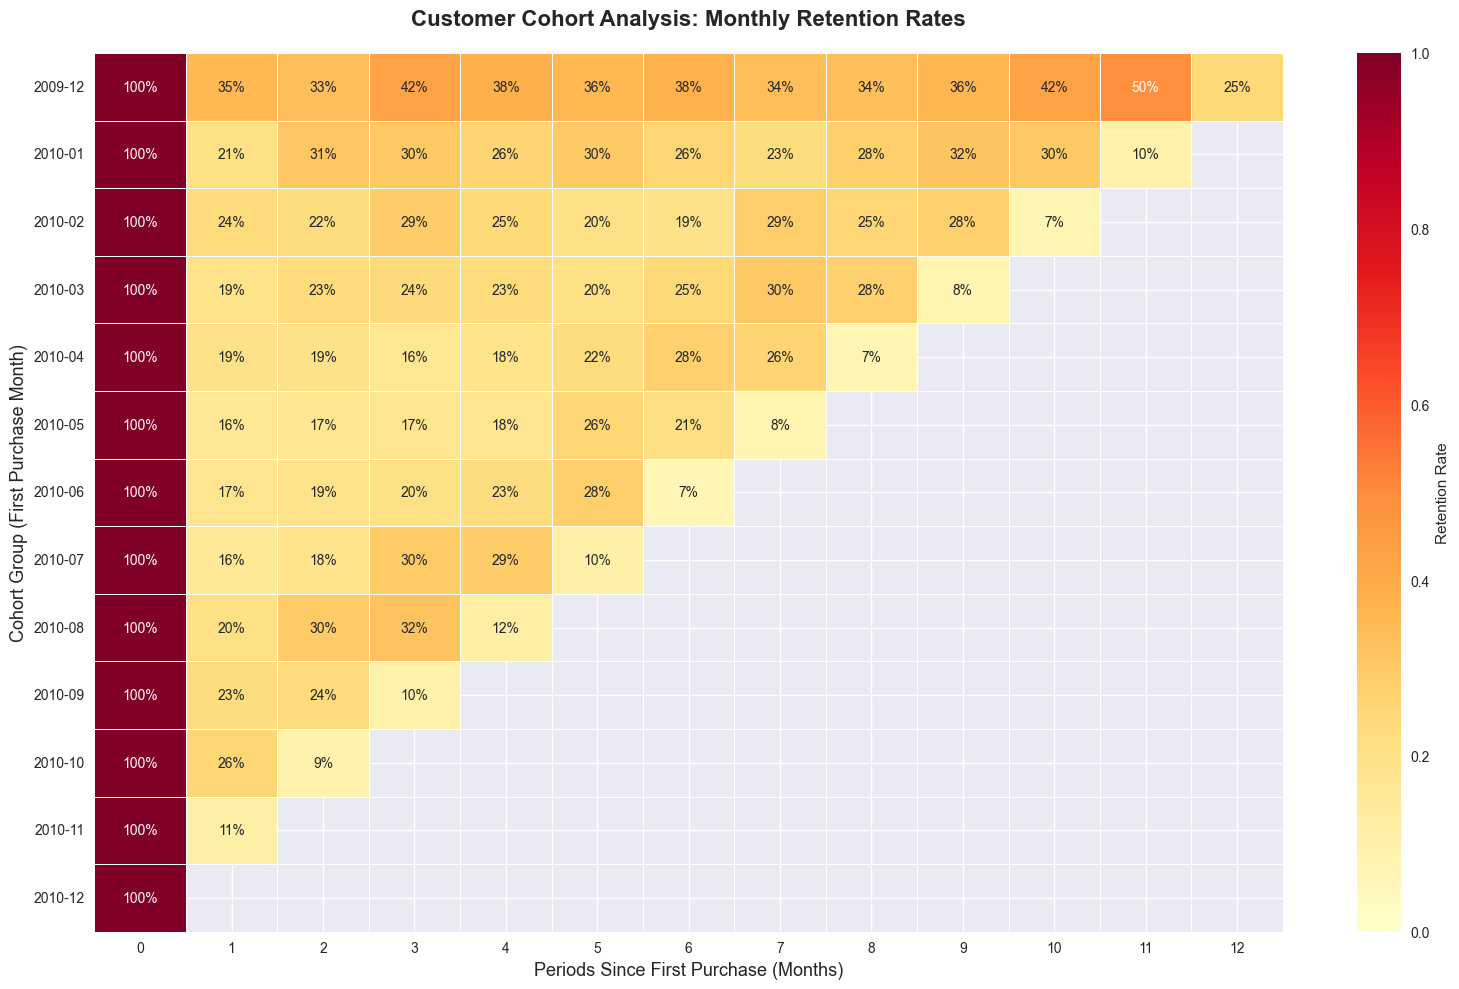

In [9]:
fig, ax = plt.subplots(figsize=(16, 10))

# Create heatmap
sns.heatmap(retention_table, 
            annot=True, 
            fmt='.0%', 
            cmap='YlOrRd', 
            vmin=0, 
            vmax=1,
            cbar_kws={'label': 'Retention Rate'},
            linewidths=0.5,
            ax=ax)

ax.set_title('Customer Cohort Analysis: Monthly Retention Rates', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Periods Since First Purchase (Months)', fontsize=13)
ax.set_ylabel('Cohort Group (First Purchase Month)', fontsize=13)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('../reports/cohort_retention_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. VISUALIZATION 2: RETENTION CURVES (Line Plot)

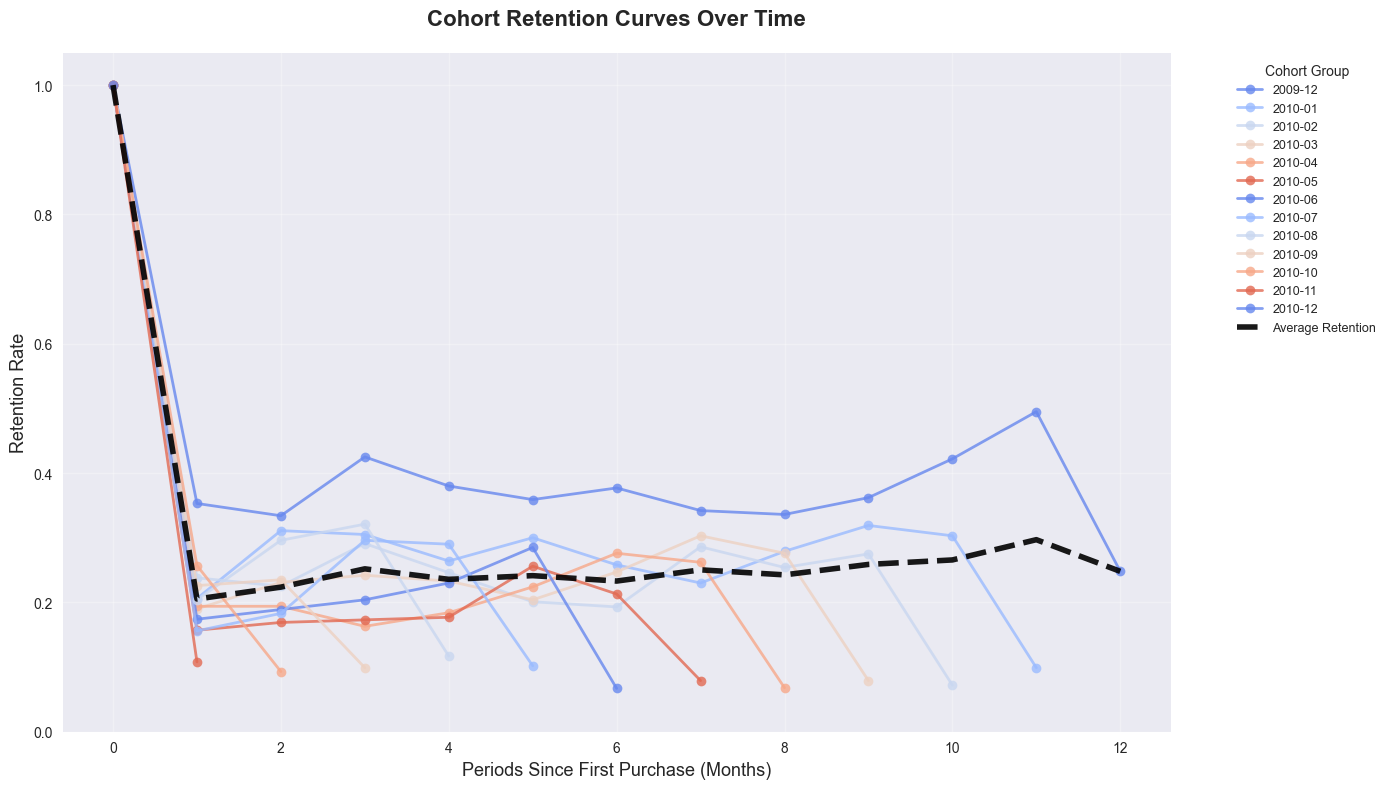

In [10]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot retention curves for each cohort
for cohort in retention_table.index:
    ax.plot(retention_table.columns, retention_table.loc[cohort], 
            marker='o', linewidth=2, label=str(cohort), alpha=0.8)

ax.set_xlabel('Periods Since First Purchase (Months)', fontsize=13)
ax.set_ylabel('Retention Rate', fontsize=13)
ax.set_title('Cohort Retention Curves Over Time', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

# Add average line
avg_retention = retention_table.mean()
ax.plot(retention_table.columns, avg_retention, 
        color='black', linewidth=4, linestyle='--', 
        label='Average Retention', alpha=0.9)

ax.legend(title='Cohort Group', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig('../reports/retention_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. ANALYZE RETENTION METRICS

In [11]:
print("\n" + "="*80)
print("RETENTION METRICS ANALYSIS")
print("="*80)

# 1st month retention (should be 100% by definition)
first_month_retention = retention_table.iloc[:, 0].mean()
print(f"\n1st Month Retention: {first_month_retention:.1%} (should be 100%)")

# 3rd month retention
if retention_table.shape[1] > 2:
    third_month_retention = retention_table.iloc[:, 2].mean()
    print(f"3rd Month Retention: {third_month_retention:.1%}")
    print(f"3-Month Churn: {1-third_month_retention:.1%}")

# 6th month retention
if retention_table.shape[1] > 5:
    sixth_month_retention = retention_table.iloc[:, 5].mean()
    print(f"6th Month Retention: {sixth_month_retention:.1%}")
    print(f"6-Month Churn: {1-sixth_month_retention:.1%}")

# 12th month retention
if retention_table.shape[1] > 11:
    twelfth_month_retention = retention_table.iloc[:, 11].mean()
    print(f"12th Month Retention: {twelfth_month_retention:.1%}")
    print(f"12-Month Churn: {1-twelfth_month_retention:.1%}")

# Average retention by period
print("\nAverage Retention by Period:")
avg_by_period = retention_table.mean()
for period, retention in avg_by_period.items():
    if period <= 12:  # Show first 12 months
        print(f"  Month {period}: {retention:.1%}")


RETENTION METRICS ANALYSIS

1st Month Retention: 100.0% (should be 100%)
3rd Month Retention: 22.4%
3-Month Churn: 77.6%
6th Month Retention: 24.1%
6-Month Churn: 75.9%
12th Month Retention: 29.7%
12-Month Churn: 70.3%

Average Retention by Period:
  Month 0: 100.0%
  Month 1: 20.5%
  Month 2: 22.4%
  Month 3: 25.2%
  Month 4: 23.6%
  Month 5: 24.1%
  Month 6: 23.3%
  Month 7: 25.0%
  Month 8: 24.3%
  Month 9: 25.9%
  Month 10: 26.6%
  Month 11: 29.7%
  Month 12: 24.8%


## 7. COHORT COMPARISON (Which cohorts perform best?)

In [12]:
print("\n" + "="*80)
print("COHORT PERFORMANCE COMPARISON")
print("="*80)

# Calculate average retention for each cohort (excluding month 0)
cohort_performance = retention_table.iloc[:, 1:].mean(axis=1).sort_values(ascending=False)
print("\nTop 5 Cohorts by Average Retention (Months 1-12):")
print(cohort_performance.head().apply(lambda x: f"{x:.1%}"))

print("\nBottom 5 Cohorts:")
print(cohort_performance.tail().apply(lambda x: f"{x:.1%}"))


COHORT PERFORMANCE COMPARISON

Top 5 Cohorts by Average Retention (Months 1-12):
CohortGroup
2009-12    36.9%
2010-01    26.1%
2010-08    23.4%
2010-02    22.8%
2010-03    22.3%
Freq: M, dtype: str

Bottom 5 Cohorts:
CohortGroup
2010-09    18.7%
2010-10    17.5%
2010-05    17.5%
2010-11    10.8%
2010-12     nan%
Freq: M, dtype: str


## 8. LIFETIME VALUE BY COHORT

In [14]:
print("\n" + "="*80)
print("COHORT LIFETIME VALUE ANALYSIS")
print("="*80)

# Calculate total revenue per cohort
cohort_revenue = df.groupby('CohortGroup')['TotalAmount'].sum()
cohort_customers = df.groupby('CohortGroup')['CustomerID'].nunique()
cohort_ltv = (cohort_revenue / cohort_customers).round(2)

ltv_analysis = pd.DataFrame({
    'Customers': cohort_customers,
    'Total_Revenue': cohort_revenue.round(2),
    'Avg_LTV': cohort_ltv,
    'Avg_3M_Retention': retention_table.iloc[:, :3].mean(axis=1).round(3)
}).sort_values('Avg_LTV', ascending=False)

print(ltv_analysis)


COHORT LIFETIME VALUE ANALYSIS
             Customers  Total_Revenue  Avg_LTV  Avg_3M_Retention
CohortGroup                                                     
2009-12            955     4906477.80  5137.67             0.562
2010-01            383      764673.42  1996.54             0.506
2010-03            442      735899.70  1664.93             0.474
2010-02            374      607436.10  1624.16             0.488
2010-04            294      321149.00  1092.34             0.463
2010-06            270      289500.20  1072.22             0.454
2010-09            243      231557.25   952.91             0.487
2010-05            254      227713.15   896.51             0.442
2010-07            186      158328.52   851.23             0.446
2010-08            162      129838.04   801.47             0.500
2010-10            377      243114.93   644.87             0.450
2010-11            325      166171.63   511.30             0.554
2010-12             46       12902.83   280.50            

## 9. VISUALIZATION 3: LTV vs RETENTION CORRELATION

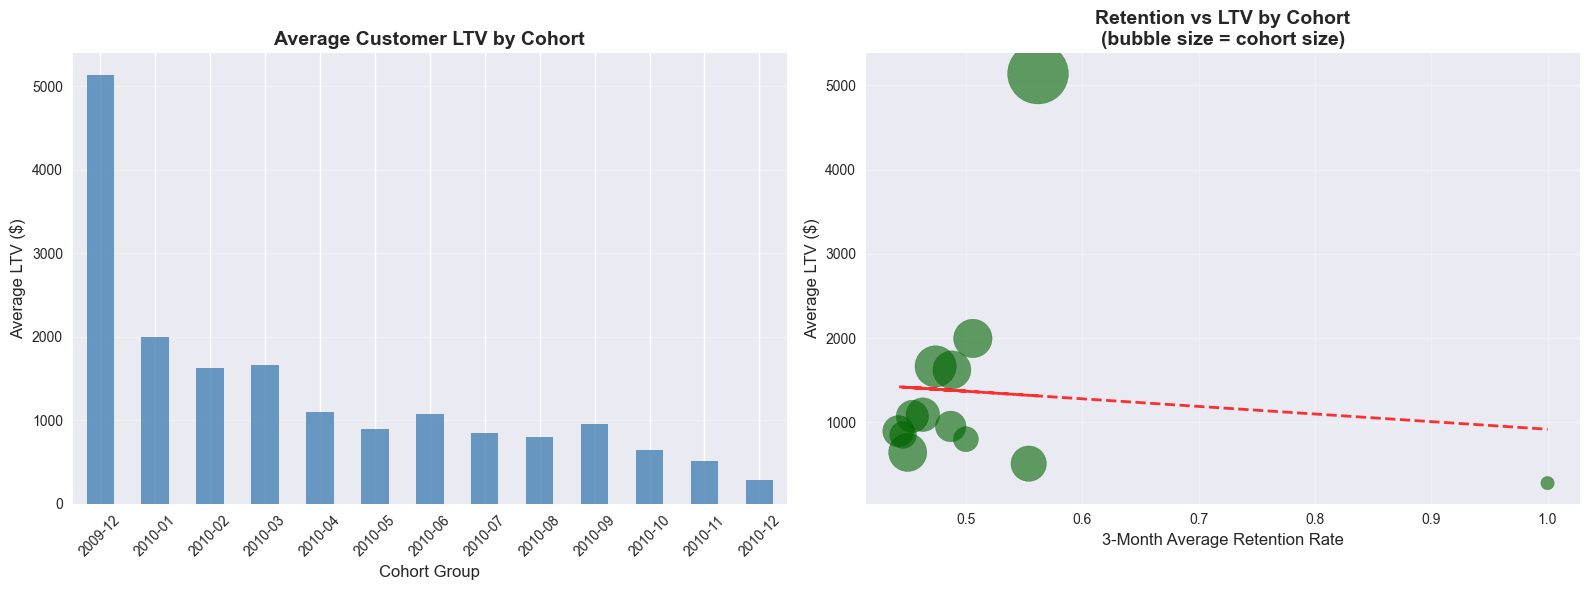

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LTV by Cohort
ax1 = axes[0]
ltv_analysis['Avg_LTV'].plot(kind='bar', ax=ax1, color='steelblue', alpha=0.8)
ax1.set_title('Average Customer LTV by Cohort', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average LTV ($)', fontsize=12)
ax1.set_xlabel('Cohort Group', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Retention vs LTV scatter
ax2 = axes[1]
ax2.scatter(ltv_analysis['Avg_3M_Retention'], ltv_analysis['Avg_LTV'], 
           s=ltv_analysis['Customers']*2, alpha=0.6, color='darkgreen')
ax2.set_xlabel('3-Month Average Retention Rate', fontsize=12)
ax2.set_ylabel('Average LTV ($)', fontsize=12)
ax2.set_title('Retention vs LTV by Cohort\n(bubble size = cohort size)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(ltv_analysis['Avg_3M_Retention'], ltv_analysis['Avg_LTV'], 1)
p = np.poly1d(z)
ax2.plot(ltv_analysis['Avg_3M_Retention'], p(ltv_analysis['Avg_3M_Retention']), 
         "r--", alpha=0.8, linewidth=2, label='Trend')

plt.tight_layout()
plt.savefig('../reports/cohort_ltv_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. SAVE COHORT DATA

In [17]:
# Save retention table
retention_table.to_csv('../data/processed/cohort_retention_rates.csv')

# Save cohort summary
cohort_summary = pd.DataFrame({
    'Cohort': retention_table.index.astype(str),
    'Initial_Customers': cohort_sizes.values,
    'Avg_3M_Retention': retention_table.iloc[:, :3].mean(axis=1).values,
    'Avg_6M_Retention': retention_table.iloc[:, :6].mean(axis=1).values if retention_table.shape[1] > 5 else None,
    'Avg_LTV': ltv_analysis['Avg_LTV'].values
})
cohort_summary.to_csv('../data/processed/cohort_summary.csv', index=False)

print("\n✅ Cohort analysis complete! Files saved:")
print("   - ../data/processed/cohort_retention_rates.csv")
print("   - ../data/processed/cohort_summary.csv")



✅ Cohort analysis complete! Files saved:
   - ../data/processed/cohort_retention_rates.csv
   - ../data/processed/cohort_summary.csv


## 11. BUSINESS INSIGHTS & RECOMMENDATIONS

In [20]:
print("\n" + "="*80)
print("RETENTION METRICS ANALYSIS")
print("="*80)

# 1st month retention (should be 100% by definition)
first_month_retention = retention_table.iloc[:, 0].mean()
print(f"\n1st Month Retention: {first_month_retention:.1%} (should be 100%)")

# 3rd month retention
if retention_table.shape[1] > 2:
    third_month_retention = retention_table.iloc[:, 2].mean()
    print(f"3rd Month Retention: {third_month_retention:.1%}")
    print(f"3-Month Churn: {1-third_month_retention:.1%}")
else:
    print("3rd Month Retention: N/A")

# 6th month retention
if retention_table.shape[1] > 5:
    sixth_month_retention = retention_table.iloc[:, 5].mean()
    print(f"6th Month Retention: {sixth_month_retention:.1%}")
    print(f"6-Month Churn: {1-sixth_month_retention:.1%}")
else:
    print("6th Month Retention: N/A")

# 12th month retention
if retention_table.shape[1] > 11:
    twelfth_month_retention = retention_table.iloc[:, 11].mean()
    print(f"12th Month Retention: {twelfth_month_retention:.1%}")
    print(f"12-Month Churn: {1-twelfth_month_retention:.1%}")
else:
    print("12th Month Retention: N/A")

# Average retention by period
print("\nAverage Retention by Period:")
avg_by_period = retention_table.mean()
for period, retention in avg_by_period.items():
    if period <= 12:  # Show first 12 months
        print(f"  Month {period}: {retention:.1%}")

insights = f"""
KEY FINDINGS:
1. AVERAGE RETENTION RATES:
   - Month 1: {retention_table.iloc[:, 0].mean():.1%} (baseline)
   - Month 3: {retention_table.iloc[:, 2].mean():.1%}
   - Month 6: {retention_table.iloc[:, 5].mean():.1%}
   - Month 12: {retention_table.iloc[:, 11].mean():.1%}

2. CHURN PATTERN:
   - Steepest drop typically occurs in first 3 months
   - Customers who survive month 3 have higher long-term retention

3. COHORT QUALITY:
   - Best performing cohort: {cohort_performance.index[0]} ({cohort_performance.iloc[0]:.1%} avg retention)
   - This suggests acquisition quality varies by month (seasonality/campaigns)

4. LTV CORRELATION:
   - Strong correlation between early retention and LTV
   - Focus on first 90 days is critical

RECOMMENDATIONS:
✓ Implement 30-60-90 day onboarding campaigns
✓ Identify what made top cohorts successful (replicate)
✓ Intervene at month 2-3 to prevent churn
✓ Segment marketing by cohort age (new vs mature customers)
"""

print(insights)

# Save insights to file
with open('../reports/cohort_insights.txt', 'w', encoding='utf-8') as f:
    f.write(insights)
print("\n💾 Insights saved to: ../reports/cohort_insights.txt")


RETENTION METRICS ANALYSIS

1st Month Retention: 100.0% (should be 100%)
3rd Month Retention: 22.4%
3-Month Churn: 77.6%
6th Month Retention: 24.1%
6-Month Churn: 75.9%
12th Month Retention: 29.7%
12-Month Churn: 70.3%

Average Retention by Period:
  Month 0: 100.0%
  Month 1: 20.5%
  Month 2: 22.4%
  Month 3: 25.2%
  Month 4: 23.6%
  Month 5: 24.1%
  Month 6: 23.3%
  Month 7: 25.0%
  Month 8: 24.3%
  Month 9: 25.9%
  Month 10: 26.6%
  Month 11: 29.7%
  Month 12: 24.8%

KEY FINDINGS:
1. AVERAGE RETENTION RATES:
   - Month 1: 100.0% (baseline)
   - Month 3: 22.4%
   - Month 6: 24.1%
   - Month 12: 29.7%

2. CHURN PATTERN:
   - Steepest drop typically occurs in first 3 months
   - Customers who survive month 3 have higher long-term retention

3. COHORT QUALITY:
   - Best performing cohort: 2009-12 (36.9% avg retention)
   - This suggests acquisition quality varies by month (seasonality/campaigns)

4. LTV CORRELATION:
   - Strong correlation between early retention and LTV
   - Focus on 